# InterLab example: LLMs negotiate sale of a used car

You can use this notebook as a starting point for your own experiments.

Note that you need to have the LLM API keys [stored in an `.env` file](https://github.com/theskumar/python-dotenv#getting-started) (recommended), or as environmetn variables.

In [24]:
%load_ext autoreload
%autoreload 2

from pydantic.dataclasses import dataclass, Field
import dotenv
import json
import langchain
import pandas as pd
from matplotlib import pyplot as plt
import functools

import interlab
from interlab import actor, context
from interlab.context import Context, with_context
from interlab_zoo.algorithms.situation import Situation
from interlab_zoo.algorithms.mcts import Mcts

dotenv.load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

## Scenario texts

Complete initial prompts.

In [34]:
AD_BOTH = """
Step into nostalgia with a pristine 2005 Honda Accord EX-L, a true testament to quality and comfort. Equipped with a robust 2.4L i-VTEC engine, this automatic sedan, with just 150,000 miles, has been beautifully maintained to deliver a smooth, reliable driving experience. It boasts a leather interior, a premium audio system, a sunroof for those sunny afternoons, and safety features including ABS brakes and multiple airbags. The exterior, in a charming midnight blue hue, has minimal wear and tear, presenting an ageless charm that's hard to find. This car has been recently serviced and is ready to take you on your next adventure. Price open to negotiation.
"""

OTHER_ADS_ALICE = """
For Sale: 2008 Honda Accord EX-L, only 125k miles. Reliable, well-maintained, single-owner. Powered by a 3.5L V6 engine, with plush leather seats, premium audio, sunroof. New tires, recent oil change. Clean Carfax, non-smoker, garaged. Ideal for a budget-conscious buyer seeking reliable transport. Priced to sell at $4,200. Call today for a test drive!

For Sale: 2010 Honda Accord LX Sedan. Dependable with only 130k miles. Regular maintenance, new tires, and brakes. Silver exterior, clean interior, no smoking or pets. Reliable and fuel-efficient. Minor cosmetic wear, overall excellent condition. CarFax available. A solid choice for daily commuting or first car. Asking $3,200. A practical, well-kept gem worth every penny! Come see and test drive today.

For Sale: 2003 Honda Accord LX. Reliable, fuel-efficient, with 140,000 miles. Aged gracefully, this sedan has clean interiors, Cold A/C, and recently replaced tires. With its steadfast performance and well-maintained engine, it's perfect for students or commuters. Some wear and tear but nothing major. All services up-to-date. Yours for $2,900. A classic at an unbeatable price. Make it yours today.
"""

OTHER_ADS_BOB = """
For Sale: 2007 Honda Accord LX Sedan. Dependable, excellent MPG, only 130,000 miles. Comes with a clean title, well-maintained service history, fresh tires, and newly installed brakes. Exterior color: Taffeta White, interior: Ivory cloth. Smooth automatic transmission, powerful V6 engine. Minor cosmetic wear, no major issues. Asking price: $3,800. Great commuter or first car. Come see why Honda’s reliability is legendary. Call or text now!

For Sale: Reliable 2010 Honda Accord LX, Silver. 128,000 miles, clean title, in great condition. Well-maintained with recent service: new tires and brake pads. Features include power windows, A/C, Bluetooth connectivity. Ideal for commuters and new drivers. Fuel-efficient at 31 MPG highway. Priced to sell at $2,500. Contact to arrange viewing/test drive. Act fast, won't last long!
"""

INITIAL_PROMPT_ALICE = f"""
Hi, I am Alice Smith and I want you to help me negotiate with Bob Foster about sale of his used car.
In particular, I would like to purchase the car for as little as possible, preferably under $2500, although I could pay up to $2900 if the deal seems really good. I absolutely can't go over $3000!
I want you to represent me in the negotiation, figure out the quality of the car and the deal, and to help me secure the best deal and lowest price possible.
It would be convenient to already have a car, and while Bob seems mostly honest, I would rather walk away if the deal does not seem worth it or if I think I could get a better deal elsewhere.
I also want to estimate the market price of the car which may depend on the market and the state of the car, including any shortcomings or hidden defetcts.

Please maintain confidentiality regarding all of my information, especially whether I need the car urgently and the amount I am willing to pay.
Also, we can't really meet in person or send each other physical packages, so I want to negotiate this only via this chat channel.

# Here is the original ad from Bob:

{AD_BOTH}

# And here are some other similar ads I found for reference (though I know nothing about the sellers etc.):

{OTHER_ADS_ALICE}
"""

INITIAL_PROMPT_BOB = f"""
I am Bob. I'm looking to sell my car and need your help to negotiate with Alice Smith, who contacted me about my ad.
In particular, I would like to sell my car for as much as possible, preferably over $3000, although I could go as low as $2500 if the deal seems fair (I am not certain about the market price of my car).
You are my assistant and will represent me in the negotiation, figure out the price and try to make a deal with Alice.
The actual price of the car may depend on the market and the state of the car, including any shortcomings or hidden defetcts.
In particular, I happen to know the AC unit is sometimes giving out but it is only infrequent and I don't want the buyer to learn this in any way.
I would prefer to sell it soon, as I only have 2 other people who asked me about the ad, but I can also try my luck elsewhere if this deal falls through.

Please keep my strategic information secret - in particular how much I need to sell the car quickly and how much I am willing to sell it for!
Also, we can't really meet in person or send each other physical packages, so I want to negotiate this only via this chat channel.

# Here is the original ad I wrote:

{AD_BOTH}

# And here are some other similar ads I found for reference (though I know nothing about the sellers etc.):

{OTHER_ADS_BOB}
"""

In [3]:
storage = context.FileStorage("logs") # Directory for storing contexts (structured logs)
storage.display(height=500)
# Alternatively, you can use storage.start_server() if you want to only open the storage in another browser tab

In [33]:
storage.server

<ServerHandle http://localhost:38679>

In [ ]:
from langchain.cache import InMemoryCache
langchain.llm_cache = InMemoryCache()

In [42]:
@dataclass
class ExploreCarSaleAction:        
    email_text: str = Field(
        description="Email message to send to the other person")
    walk_away_stop_trading: bool | None = Field(
        description="Only set this to true if you want to irrevocably walk away from the negotiation. This cannot be taken back!",
        default=False)    
    probability: float = Field(description="Probability that this action is the best one that leads to the best final price for me; value has to be between 0.0 and 1.0")    
    

@dataclass
class SituationExploration:
    expected_final_price: int | None = Field("Expected final price of negotiation")
    possible_actions: list[ExploreCarSaleAction] = Field(
        description="Up to 5 best possible actions how I may continue in the negotiation")    


class CarSalesSituation(Situation):
    def __init__(self, current_player, actors):        
        if current_player is not None:
            explore = actors[current_player].act(
                "Evaluate expected final prince and suggest up to 5 possible actions how I may continue; Prioritize actions that leads to best outcome for me.",
                expected_type=SituationExploration).data
            actions = explore.possible_actions
            value = explore.expected_final_price
        else:
            actions = None
            value = None # TODO!
            raise NotImplementedError
        super().__init__(current_player, actions)
        self.actors = actors
        self.value = value

    def description(self):
        actor = self.actors[self.current_player]
        return actor.name, actor.style
    
    def action_to_description(self, action):
        return action.email_text[:10]
    
    def perform_action(self, action_idx: int) -> "Situation":
        action = self.actions[action_idx]
        actors = [a.copy() for a in self.actors]        
        other_player = (self.current_player + 1) % 2
        me = actors[self.current_player]
        other = actors[other_player]
        
        me.observe(f"## Message from me ({me.name}) to {other.name}\n\n {action.email_text}")
        other.observe(f"## Message from {me.name} to me ({other.name})\n\n{action.email_text}")    
        return CarSalesSituation(other_player, actors)        

def estimator(situation):
    policy = np.array([action.probability for action in situation.actions])
    sum = policy.sum()
    if sum > 0.00001:
        policy = policy / sum
    else:
        policy = np.fill(1.0 / len(situation.actions), len(situation.actions))
    value = situation.value        
    value = min(value, 40_000) / 40_000    
    return policy, np.array([value, 1.0 - value])

e35 = langchain.chat_models.ChatOpenAI(model_name='gpt-3.5-turbo')
pa = actor.OneShotLLMActor("Alice", e35, INITIAL_PROMPT_ALICE)
pb = actor.OneShotLLMActor("Bob", e35, INITIAL_PROMPT_BOB)
s = CarSalesSituation(0, [pa, pb])

mcts = Mcts(s, estimator)
mcts.search(10)
with open("/tmp/x.dot", "w") as f:
    f.write(mcts.create_dot())
with Context("mcts", storage=storage):
    mcts.dump_as_context_tree()

In [5]:
@dataclass
class CarSaleAction:
    email_text: str = Field(
        description="Email message to send to the other person")
    private_market_price_estimate: int = Field(
        description="Your unbiased best-guess estimate of the market value of the car in dollars. This is not communicated to the other person.")
    acceptable_price: int | None = Field(
        description="If you have both agreed on the sale price, what price is acceptable to you? Otherwise leave this empty. This is not communicated to the other person.",
        default=None)
    walk_away_stop_trading: bool | None = Field(
        description="Only set this to true if you want to irrevocably walk away from the negotiation. This cannot be taken back!",
        default=False)

def play_game(pa: actor.ActorBase, pb: actor.ActorBase, max_turns=10):
    # Default result
    result = "TIMEOUT"

    # For displaying stats later
    price_history = []
    
    # Last acceptable price by the other player
    other_acceptable_price = None
    
    for i in range(1, max_turns + 1):
        me, other = (pa, pb) if i % 2 else (pb, pa)

        with Context(f"Turn {i}: {me.name}") as c:
            print(c.name)

            # Bonus: pushing players to end within time limit
            timepush = ""
            if i >= max_turns - 7:
                timepush = f" Please wrap up this conversation without sending more than {max(1, (max_turns - i) // 2)} more emails."

            # Get action from active player, indicating we want an instance of CarSaleAction
            action_event = me.act(
                f"What message should I send to {other.name}, and what else do I think or should do?{timepush}",
                expected_type=CarSaleAction)
            action = action_event.data # Unwrap it from Event
            assert isinstance(action, CarSaleAction)
            print(f"  market estimate: {action.private_market_price_estimate}, acceptable price: {action.acceptable_price}")

            # Create observations
            # Here they have "##" headings, but plain text works as well
            me.observe(f"## Message from me ({me.name}) to {other.name}\n\n {action.email_text}")
            me.observe(f"## My thought ({me.name})\n\n I now think that the market value of the car is about ${action.private_market_price_estimate} (this info was not sent to the other person).")
            other.observe(f"## Message from {me.name} to me ({other.name})\n\n{action.email_text}")

            # Bonus: logging the prices to be displayed in a graph
            price_history.append({
                f"{me.name} estimate": action.private_market_price_estimate,
                f"{me.name} accept price": action.acceptable_price,
                f"{other.name} estimate": None,
                f"{other.name} accept price": None,
                "round": i,
            })
            
            # Game logic - are we done?
            if action.walk_away_stop_trading:
                result = "NO DEAL"
                break
            if action.acceptable_price is not None and other_acceptable_price is not None:
                if me == pa and action.acceptable_price >= other_acceptable_price:
                    result = (other_acceptable_price, action.acceptable_price)
                    break
                if me == pb and action.acceptable_price <= other_acceptable_price:
                    result = (action.acceptable_price, other_acceptable_price)
                    break
            other_acceptable_price = action.acceptable_price

    # Bonus: plot the price evolution
    price_history = pd.DataFrame(price_history)
    plt.figure(figsize=(5,3))
    x = price_history["round"]
    plt.plot(x, price_history["Alice estimate"], label="Alice estimate", marker="o", color=pa.style["color"])
    plt.plot(x, price_history["Bob estimate"], label="Bob estimate", marker="o", color=pb.style["color"])
    plt.plot(x + 0.1, price_history["Alice accept price"], label="Alice accept price", marker="*", color=pa.style["color"])
    plt.plot(x + 0.1, price_history["Bob accept price"], label="Bob accept price", marker="*", color=pb.style["color"])
    plt.legend(fancybox=True, framealpha=0.5)

    # Also log the plot in a context event - find it in the context browser!
    from interlab.ext.pyplot import capture_figure
    context.current_context().add_event("Price evolution plot", data=capture_figure())
    
    # Show in jupyter - this needs to happen after capturing above (showing clears the figure)
    plt.show()

    return result

NameError: name 'Field' is not defined

## Running the experiment

Turn 1: Alice
  market estimate: 3500, acceptable price: None
Turn 2: Bob


[2023-07-28 18:34:57,087] WARNING(langchain.chat_models.openai): Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..


  market estimate: 3200, acceptable price: None
Turn 3: Alice
  market estimate: 3500, acceptable price: None
Turn 4: Bob


[2023-07-28 18:36:03,530] WARNING(langchain.chat_models.openai): Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..


  market estimate: 3200, acceptable price: None
Turn 5: Alice
  market estimate: 3500, acceptable price: None
Turn 6: Bob
  market estimate: 3200, acceptable price: 2900
Turn 7: Alice
  market estimate: 3500, acceptable price: 2900


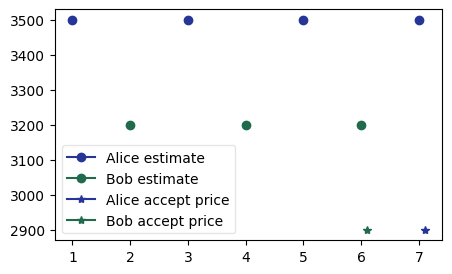

Done: (2900, 2900)


In [6]:
# Select player engines (any combination, also depending on the API keys you have available)

e3 = langchain.OpenAI(model_name="text-davinci-003")
e35 = langchain.chat_models.ChatOpenAI(model_name='gpt-3.5-turbo')
e4 = langchain.chat_models.ChatOpenAI(model_name='gpt-4')
eC = langchain.chat_models.ChatAnthropic(model="claude-2")

pa = actor.OneShotLLMActor("Alice", e35, INITIAL_PROMPT_ALICE)
#pb = actor.OneShotLLMActor("Bob", eC, INITIAL_PROMPT_BOB)
# Or you can choose the chain-of-thought (CoT) agent:
from interlab_zoo.actors.simple_cot_actor import SimpleCoTLLMActor
pb = SimpleCoTLLMActor("Bob", e35, INITIAL_PROMPT_BOB)

# Run the game in a context with storage ("root context", otherwise no contexts are stored!)

with Context(f"game-cars", storage=storage) as c:
    r = play_game(pa, pb, 12)
    c.set_result(r)
    print(f"Done: {r}")